# Data Analyzer for Aurora QA System
This notebook analyzes member message data and creates visualizations saved to the `analysis-artifacts/` folder.


In [1]:
import asyncio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pathlib import Path
from collections import Counter, defaultdict
from datetime import datetime

# Set up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Create analysis-artifacts directory if it doesn't exist
ARTIFACTS_DIR = Path('analysis-artifacts')
ARTIFACTS_DIR.mkdir(exist_ok=True)
print(f"Analysis artifacts will be saved to: {ARTIFACTS_DIR.absolute()}")


Analysis artifacts will be saved to: /Users/venkatachalamsubramanianperiyasubbu/Desktop/GitHub/qa-system/analysis-artifacts


In [2]:
# Import data fetcher
from data_fetcher import DataFetcher

# Fetch all member data
data_fetcher = DataFetcher()
member_data = await data_fetcher.fetch_all_messages()

print(f"Total messages fetched: {len(member_data)}")


Error fetching messages: 403, message='Forbidden', url='https://november7-730026606190.europe-west1.run.app/messages/?skip=1600&limit=100'
API limit/restriction reached at 1600 messages. Using 1600 messages for processing.


Total messages fetched: 1600


## Basic Statistics


In [7]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(member_data)

# Basic statistics
print("\n=== BASIC STATISTICS ===")
print(f"Total messages: {len(df)}")
print(f"Unique members: {df['member_name'].nunique()}")
print(f"Average message length: {df['content'].str.len().mean():.2f} characters")
print(f"\nMessages per member:")
print(df['member_name'].value_counts())



=== BASIC STATISTICS ===
Total messages: 100
Unique members: 10
Average message length: 63.62 characters

Messages per member:
member_name
Sophia Al-Farsi       16
Fatima El-Tahir       15
Hans Müller           11
Layla Kawaguchi       10
Vikram Desai          10
Lily O'Sullivan       10
Armand Dupont          8
Thiago Monteiro        8
Lorenzo Cavalli        7
Amina Van Den Berg     5
Name: count, dtype: int64


## Visualization 1: Messages per Member


Saved: analysis-artifacts/messages_per_member.png


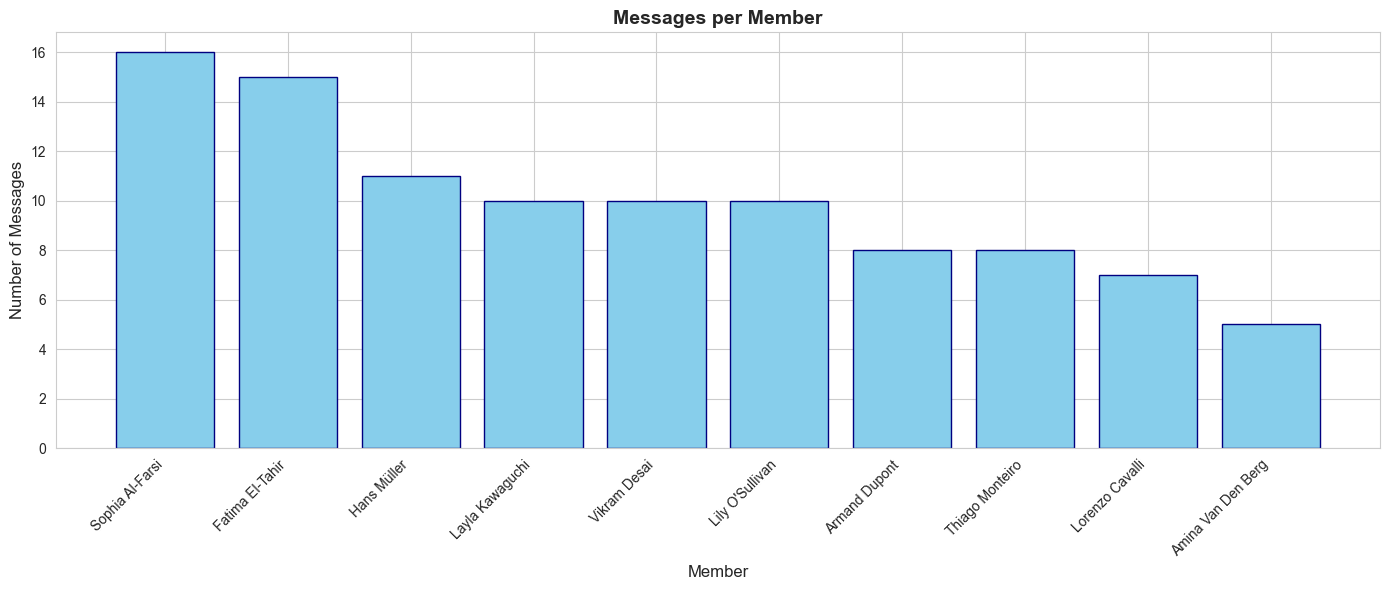

In [8]:
# Plot messages per member
plt.figure(figsize=(14, 6))
member_counts = df['member_name'].value_counts()
plt.bar(range(len(member_counts)), member_counts.values, color='skyblue', edgecolor='navy')
plt.xlabel('Member', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.title('Messages per Member', fontsize=14, fontweight='bold')
plt.xticks(range(len(member_counts)), member_counts.index, rotation=45, ha='right')
plt.tight_layout()

# Save figure
save_path = ARTIFACTS_DIR / 'messages_per_member.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()


## Visualization 2: Message Length Distribution


Saved: analysis-artifacts/message_length_distribution.png


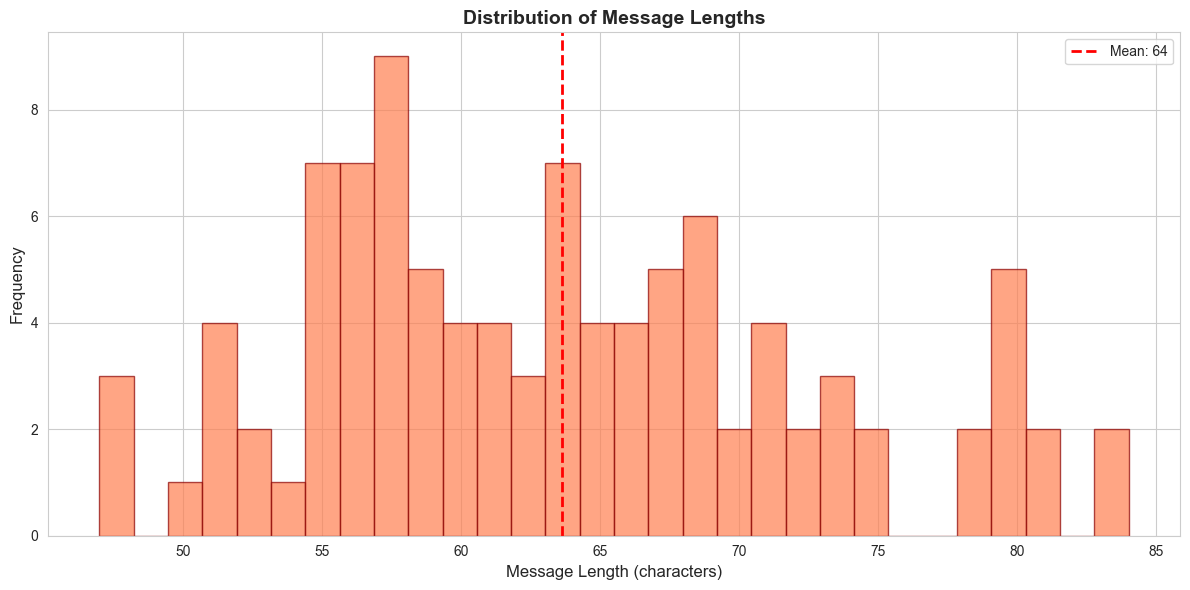

In [9]:
# Plot message length distribution
plt.figure(figsize=(12, 6))
message_lengths = df['content'].str.len()
plt.hist(message_lengths, bins=30, color='coral', edgecolor='darkred', alpha=0.7)
plt.xlabel('Message Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Message Lengths', fontsize=14, fontweight='bold')
plt.axvline(message_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {message_lengths.mean():.0f}')
plt.legend()
plt.tight_layout()

# Save figure
save_path = ARTIFACTS_DIR / 'message_length_distribution.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()


## Data Quality Analysis


In [10]:
# Check for missing fields
print("\n=== DATA QUALITY CHECK ===")
print("\nMissing values:")
print(df.isnull().sum())

# Check for empty content
empty_content = df[df['content'].str.strip() == '']
print(f"\nMessages with empty content: {len(empty_content)}")

# Check for duplicate messages
duplicates = df[df.duplicated(subset=['content'], keep=False)]
print(f"Duplicate messages: {len(duplicates)}")



=== DATA QUALITY CHECK ===

Missing values:
id             0
member_name    0
content        0
timestamp      0
user_id        0
dtype: int64

Messages with empty content: 0
Duplicate messages: 0


## Anomaly Detection


In [11]:
# Detect outliers in message length
import numpy as np

message_lengths = df['content'].str.len()
mean_length = message_lengths.mean()
std_length = message_lengths.std()

# Find messages that are 3 standard deviations away
outliers = df[np.abs((message_lengths - mean_length) / std_length) > 3]

print("\n=== ANOMALIES DETECTED ===")
print(f"\nMessage length outliers: {len(outliers)}")
if len(outliers) > 0:
    print("\nOutlier details:")
    for idx, row in outliers.iterrows():
        print(f"  - {row['member_name']}: {len(row['content'])} characters")



=== ANOMALIES DETECTED ===

Message length outliers: 0


## Visualization 3: Data Quality Score


Saved: analysis-artifacts/data_quality_metrics.png


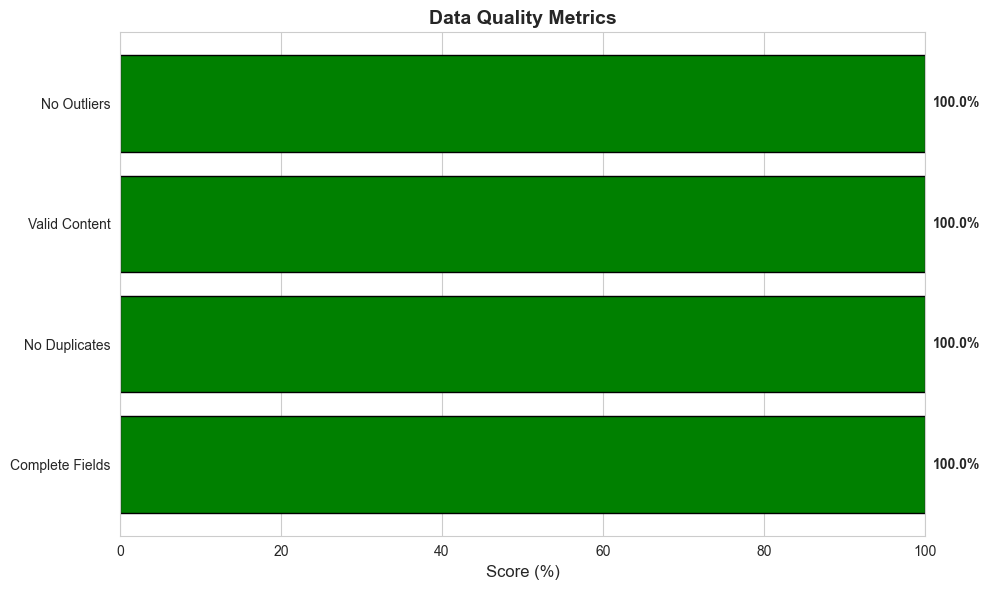


Overall Data Quality Score: 100.00%


In [12]:
# Calculate data quality metrics
total_messages = len(df)
complete_fields = df.notna().all(axis=1).sum()
no_duplicates = total_messages - len(duplicates)
valid_content = total_messages - len(empty_content)
no_outliers = total_messages - len(outliers)

quality_metrics = {
    'Complete Fields': (complete_fields / total_messages) * 100,
    'No Duplicates': (no_duplicates / total_messages) * 100,
    'Valid Content': (valid_content / total_messages) * 100,
    'No Outliers': (no_outliers / total_messages) * 100
}

# Plot quality metrics
plt.figure(figsize=(10, 6))
metrics = list(quality_metrics.keys())
scores = list(quality_metrics.values())
colors = ['green' if s > 90 else 'orange' if s > 70 else 'red' for s in scores]

plt.barh(metrics, scores, color=colors, edgecolor='black')
plt.xlabel('Score (%)', fontsize=12)
plt.title('Data Quality Metrics', fontsize=14, fontweight='bold')
plt.xlim(0, 100)

# Add value labels
for i, (metric, score) in enumerate(zip(metrics, scores)):
    plt.text(score + 1, i, f'{score:.1f}%', va='center', fontweight='bold')

plt.tight_layout()

# Save figure
save_path = ARTIFACTS_DIR / 'data_quality_metrics.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

# Calculate overall quality score
overall_quality = np.mean(scores)
print(f"\nOverall Data Quality Score: {overall_quality:.2f}%")


## Summary Report


In [13]:
# Generate summary report
summary_report = f"""
================================
DATA ANALYSIS SUMMARY REPORT
================================
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET OVERVIEW:
  - Total Messages: {total_messages}
  - Unique Members: {df['member_name'].nunique()}
  - Average Messages per Member: {total_messages / df['member_name'].nunique():.2f}
  - Average Message Length: {message_lengths.mean():.2f} characters

DATA QUALITY:
  - Overall Quality Score: {overall_quality:.2f}%
  - Complete Fields: {quality_metrics['Complete Fields']:.2f}%
  - No Duplicates: {quality_metrics['No Duplicates']:.2f}%
  - Valid Content: {quality_metrics['Valid Content']:.2f}%
  - No Outliers: {quality_metrics['No Outliers']:.2f}%

ANOMALIES:
  - Empty Content Messages: {len(empty_content)}
  - Duplicate Messages: {len(duplicates)}
  - Message Length Outliers: {len(outliers)}

ARTIFACTS SAVED:
  - messages_per_member.png
  - message_length_distribution.png
  - data_quality_metrics.png
  - summary_report.txt

All artifacts saved to: {ARTIFACTS_DIR.absolute()}
================================
"""

print(summary_report)

# Save summary report to file
report_path = ARTIFACTS_DIR / 'summary_report.txt'
with open(report_path, 'w') as f:
    f.write(summary_report)
print(f"\nSummary report saved to: {report_path}")



DATA ANALYSIS SUMMARY REPORT
Generated: 2025-11-13 23:52:32

DATASET OVERVIEW:
  - Total Messages: 100
  - Unique Members: 10
  - Average Messages per Member: 10.00
  - Average Message Length: 63.62 characters

DATA QUALITY:
  - Overall Quality Score: 100.00%
  - Complete Fields: 100.00%
  - No Duplicates: 100.00%
  - Valid Content: 100.00%
  - No Outliers: 100.00%

ANOMALIES:
  - Empty Content Messages: 0
  - Duplicate Messages: 0
  - Message Length Outliers: 0

ARTIFACTS SAVED:
  - messages_per_member.png
  - message_length_distribution.png
  - data_quality_metrics.png
  - summary_report.txt

All artifacts saved to: /Users/venkatachalamsubramanianperiyasubbu/Desktop/GitHub/qa-system/analysis-artifacts


Summary report saved to: analysis-artifacts/summary_report.txt
